In [1]:
import discoursegraphs as dg
from discoursegraphs.corpora import pcc
from discoursegraphs.readwrite.rst import rs3

## Task 1: Which syntactic subordinate clauses match with an RST EDU?
## Task 2: Are these EDUs satellites or nucleii?
## Task 3: does this correlate with certain RST relation types?


In [2]:
def get_subordinate_clauses(tiger_docgraph):
    """
    given a document graph of a TIGER syntax tree, return all
    node IDs of nodes representing subordinate clause constituents.

    Parameters
    ----------
    tiger_docgraph : dg.DiscourseDocumentGraph
        document graph from which subordinate clauses will be extracted
    
    Returns
    -------
    subord_clause_nodes : list(str)
        list of node IDs of nodes directly dominating subordinate clauses
    """
    subord_clause_rels = \
        dg.select_edges_by_attribute(
            tiger_docgraph, attribute='tiger:label',
            value=['MO', 'RC', 'SB'])
    
    subord_clause_nodes = []
    for src_id, target_id in subord_clause_rels:
        src_cat = tiger_docgraph.node[src_id].get('tiger:cat')
        if src_cat == 'S' and not dg.istoken(tiger_docgraph, target_id):
            subord_clause_nodes.append(target_id)
    return subord_clause_nodes

In [3]:
from collections import defaultdict

from intervaltree import IntervalTree, Interval

import discoursegraphs as dg
from discoursegraphs.readwrite.rst import rs3

def _spans2nodes(docgraph, nodes):
    """
    Takes a document graph and a collection of nodes
    and returns a mapping from a span to all the nodes
    that dominate that span. (There might be multiple
    nodes which cover the same span.)

    Parameters
    ----------
    docgraph : dg.DiscourseDocumentGraph
        document graph from which the span-node mapping will be extracted
    nodes : collections.Iterable(str)
        a list/collection of node IDs whose spans will be extracted

    Returns
    -------
    span2nodes : defaultdict(tuple(int, int): list(str))
        maps from the offsets of a span to a list of node IDs
        (of nodes directly dominating that span)
    """
    span2nodes = defaultdict(list)
    for node_id in nodes:
        span = dg.get_span_offsets(docgraph, node_id)
        span2nodes[span].append(node_id)
    return span2nodes

def get_max_overlaps(overlap_map):
    """
    finds the nodes with the longest overlapping span.
    TODO: needs heavy refactoring, input/output is
    hard to grasp.
    
    Parameters
    ----------
    overlap_map : defaultdict(str: list(dict))
        maps from a local node (node ID) to a list of other nodes,
        where each other node is represented as a dict
        with the keys ``node_id`` (str), ``overlap`` (float)
        and ``interval`` (tuple(int, int))
    
    Returns
    -------
    max_overlapping_nodes : dict(str: dict)
        maps from a local node (node ID str) to
        the other node (dict with keys ``node_id`` (str),
        ``overlap`` (float) and ``interval``
        (tuple(int, int))) that has the greatest overlap
        with it
    """
    # given a list of other nodes, return the one
    # with the highest overlap score
    max_overlap = lambda l: sorted(
        l, key=lambda n: n['overlap'],
        reverse=True)[0]
    return {local_node: max_overlap(overlap_map[local_node])
            for local_node in overlap_map}

In [4]:
def get_overlap_scores(local_span, overlap_interval):
    """
    calculates the overlap between the given input spans.
    
    Parameters
    ----------
    local_span : tuple(int, int)
        the onset and offset of the ``local`` span
    overlap_interval : Interval
        the onset and offset of the ``other`` span

    Returns
    -------
    overlap_ratio : float
        the percentage of overlap between the input spans
    len_overlap : the number of consecutive characters that
        the input spans share
    len_longest_input : length (in characters) of the longest
        of the two input spans
    """
    local_on, local_off = local_span
    len_local = local_off - local_on

    other_on, other_off = overlap_interval.begin, overlap_interval.end
    len_other = other_off - other_on
    len_longest_input = max(len_local, len_other)

    overlap_on = max(local_on, other_on)
    overlap_off = min(local_off, other_off)
    # length of overlap in chars (int)
    len_overlap = overlap_off - overlap_on

    # overlap (float) in % between the input intervals
    overlap_ratio = len_overlap / float(len_longest_input) * 100

    return overlap_ratio, len_overlap, len_longest_input

In [5]:
def find_overlapping_nodes(
    docgraph, local_nodes, other_nodes,
    overlap_threshold=95, debug=False, strict=False):
    """
    given a document graph and two sets of nodes (called
    ``local_nodes`` and ``other_nodes`` merely to distinguish them),
    find pairs of nodes (one ``local`` and one ``other``) which
    cover (approximately) the same span.
    
    Parameters
    ----------
    docgraph : DiscourseDocumentGraph
        the document graph in which we'll look for
        overlapping nodes
    local_nodes : collections.Iterable(str)
        a collection of node IDs
    other_nodes : collections.Iterable(str)
        a collection of node IDs.
        There's no technical difference between ``local_nodes``
        and ``other_nodes``, we justed to distinguish the
        two collections.
    overlap_threshold : int
        two spans are considered overlapping, if
        their onset/offset intervals overlap at least N %
    strict : bool
        If True, the overlap has to pass the threshold. Otherwise,
        up to two characters shorter than the longest input string
    
    Returns
    -------
    max_overlapping_nodes : dict(str: dict)
        maps from a local node (node ID str) to
        the other node (dict with keys ``node_id`` (str),
        ``overlap`` (float) and ``interval``
        (tuple(int, int))) that has the greatest overlap
        with it
    """    
    def fulfills_overlap_criteria(strict, overlap, overlap_threshold,
                                  len_overlap, len_longest_input):
        """
        returns True, if the overlap criteria are met.

        If strict is True, the overlap has to pass a threshold. Otherwise,
        the length of the overlap is allowed to be up to two characters
        shorter than the longest input string. (The strict=False option
        is therefore useful for comparing short spans with potentially
        diverging tokenization rules, e.g. 'Hello' vs. 'Hello !'.)
        """
        if strict:
            if overlap >= overlap_threshold:
                return True
        else:
            if overlap >= overlap_threshold or (len_overlap+2 >= len_longest_input):
                return True
        return False
        
    # there might be more than one node covering the same span,
    # e.g. when an NP only consists of a single noun
    local_span2nodes = _spans2nodes(docgraph, local_nodes)        
    other_span2nodes = _spans2nodes(docgraph, other_nodes)

    other_tree = IntervalTree.from_tuples(other_span2nodes.keys())
    
    # overlap_map : defaultdict(str: list(dict))
    #    maps from a local node (node ID) to a list of other nodes,
    #    where each other node is represented as a dict
    #    with the keys ``node_id`` (str), ``overlap`` (float)
    #    and ``interval`` (tuple(int, int))
    overlap_map = defaultdict(list)

    # local_span : tuple(int, int)
    for local_span in local_span2nodes:
        # overlap_intervals : set(Interval)
        # all the spans from ``other_spans`` that overlap with this ``local_span``
        overlap_intervals = other_tree[Interval(*local_span)]
        for overlap_interval in overlap_intervals:
            overlap, len_overlap, len_longest_input = \
                get_overlap_scores(local_span, overlap_interval)
            
            if fulfills_overlap_criteria(strict, overlap, overlap_threshold,
                                         len_overlap, len_longest_input):
                other_on, other_off = overlap_interval.begin, overlap_interval.end
                # generate a mapping from a local node (node ID str)
                # to all the ``other_nodes`` it overlaps with (incl.
                # their overlap in % for finding the best match)
                for local_node in local_span2nodes[local_span]:
                    overlap_span = (other_on, other_off)
                    for other_node in other_span2nodes[overlap_span]:
                        overlap_map[local_node].append(
                            {'node_id': other_node, 'overlap': overlap,
                             'interval': (other_on, other_off)})
    
    return get_max_overlaps(overlap_map)

In [6]:
matches = []

for doc_id in pcc.document_ids:
    docgraph = pcc[doc_id]
#     print docgraph.name
    
    # compare subordinate clauses to EDUs
    subord_nodes = get_subordinate_clauses(docgraph)
    edu_nodes =  rs3.get_edus(docgraph)


    overlapping_nodes_map = find_overlapping_nodes(
        docgraph, subord_nodes, edu_nodes, overlap_threshold=100, debug=True, strict=False)

    for subord_id, edu in overlapping_nodes_map.items():
        subord_clause_cat = docgraph.node[subord_id]['tiger:cat']

        edu_node_id = edu['node_id']
        segment_type = docgraph.node[edu_node_id]['rst:segment_type']

        rel_name = docgraph.node[edu_node_id].get('rst:rel_name')
        if not rel_name: # try to get the rel_name, no matter what (cf. issue #139)
            in_edges = docgraph.in_edges(edu_node_id)
            assert len(in_edges) == 1, \
                "There must be exactly one dominating node."
            dom_node_id = in_edges[0][0]
            rel_name = docgraph.node[dom_node_id]['rst:rel_name']

        # prints the subordinating clause and the EDU that it matches
#         print subord_clause_cat, edu_node_id, segment_type, rel_name
        matches.append([subord_clause_cat, segment_type, rel_name])
#     print

In [7]:
from pandas import DataFrame
import pandas

In [8]:
df = DataFrame(matches, columns=('clause', 'segment', 'relation'))

In [9]:
len(df[df.segment == 'satellite'])

168

In [10]:
len(df[df.segment == 'nucleus'])

24

In [11]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [31]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [14]:
from sklearn import preprocessing

df_numeric = df.copy()

encoders = {} # keep them for decoding the data later
for colname in df.columns:
    encoder = preprocessing.LabelEncoder()
    encoders[colname] = encoder
    df_numeric[colname] = encoder.fit_transform(df[colname])

#to convert back

# train.Sex = le_sex.inverse_transform(train.Sex)

In [15]:
# df_numeric['clause'] = encoders['clause'].inverse_transform(df_numeric['clause'])

In [16]:
import pandas as pd

In [17]:
pd.get_dummies(df.clause).head()

,AP,AVP,CNP,CO,CS,CVP,NP,PP,S,VP
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0


In [18]:
pd.get_dummies(df.segment).head()

,nucleus,satellite,span
0,0,1,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0


In [19]:
pd.concat([pd.get_dummies(df.clause).head(), pd.get_dummies(df.segment).head()], axis=1)

,AP,AVP,CNP,CO,CS,CVP,NP,PP,S,VP,nucleus,satellite,span
0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0


In [20]:
%load_ext gvmagic

In [90]:
def predict_column(df, target_column, feature_columns=None, max_depth=5, min_samples_leaf=2):
    """
    """
    # convert all feature cols w/ get_dummies & concat them
    if feature_columns is None:
        train_df = df.drop(labels=[target_column], axis=1)
    else:
        train_df = DataFrame(df, columns=feature_columns)
        
    train_binarized = pd.concat(
        (pd.get_dummies(df[col]) for col in train_df.columns), axis=1)
    
    target_series = df[target_column]
    
    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    dt.fit(train_binarized, target_series)
    return dt, train_binarized, target_series

In [86]:
from StringIO import StringIO

# # df.drop(labels=['clause'], axis=1)
# for colname in df.columns:
#     dt, train_binarized, target_series = predict_column(df, colname)

#     out = StringIO()
#     export_graphviz(dt, out_file=out)
#     %dotstr out.getvalue()

In [95]:
dt, train_binarized, target_series = predict_column(
    df, target_column='segment', feature_columns=['clause'])

In [96]:
out = StringIO()
export_graphviz(dt, out_file=out,
                feature_names=train_binarized.columns,  
                class_names=dt.classes_, 
                filled=True, rounded=True,  
                special_characters=True)

# DictVectorizer usage example

## if we can't use pandas.get_dummies() ...

In [118]:
clause_df = df[['clause']]

In [119]:
clause_df.head().to_dict()

{'clause': {0: 'S', 1: 'NP', 2: 'S', 3: 'S', 4: 'S'}}

In [121]:
clause_df.T.to_dict().values()[:10]
clause_dict = clause_df.T.to_dict().values()

In [126]:
from sklearn.feature_extraction import DictVectorizer as DV

vectorizer = DV( sparse = False )
clause_vec = vectorizer.fit_transform(clause_dict)
clause_vec

array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [130]:
df.to_csv('clause-segment-relation.csv')

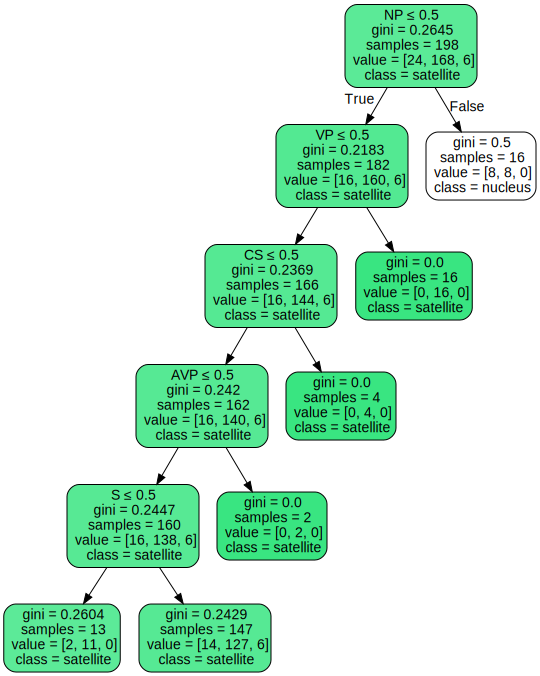

In [97]:
%dotstr out.getvalue()
# train_binarized.columns
# target_series.value_counts()

# TODO: try Frequent Itemset visualization

- Grouped matrix-based visualization
- available in ``arulesViz`` R-package
- cf. Hahsler and Chelluboina (2011). Visualizing Association Rules in Hierarchical Groups.